In [2]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from tqdm import tqdm

In [3]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [4]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw(x, a, m):
    return m*x**a

In [5]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw_simple(x, a):
    return x**a

In [6]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

In [7]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2024_02_14_dpi-1p5mm'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])


In [8]:
wave_con_df = consolidate_waves(wave_dataframe_paths)
wave_con_df['real_time'] = wave_con_df['rel_time'] * 5.0

100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 385.83it/s]


In [9]:
wave_collect_for_travel = []


for wid, wave in wave_con_df.groupby('wave_ID'):
    linear_travel_collect = []
    mean_start = np.mean(wave.wave_centroid.values[0:6])

    for t, wave_i in wave.groupby('rel_time'):
        centroid_travel_distance = np.linalg.norm(wave_i.wave_centroid.values[0]-mean_start)
        total_linear_travel = wave_i.circle_radius.values[0] + centroid_travel_distance
        linear_travel_collect.append(total_linear_travel)

    wave['linear_travel'] = linear_travel_collect
    wave_collect_for_travel.append(wave)
    
waves_linear_added = pd.concat(wave_collect_for_travel, ignore_index=True)

In [10]:
waves_linear_added

,clTrackID,timepoint,rel_time,rel_r,r_squared,circle_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,trackable,ca_avg_sig,split,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID,real_time,linear_travel
0,4,164,0,0.000000,0.000000,77.504468,2.363544,0.025416,"[593.9337406406916, 625.0046976633138]",2105.089601,True,155.067208,0.0,NaN,NaN,14,0-4,0,0.0,88.392879
1,4,165,1,11.817718,139.658457,89.322185,2.490626,0.090512,"[606.0343571465047, 626.9496190886374]",2105.358484,True,164.152264,0.0,NaN,NaN,14,0-4,0,5.0,92.712448
2,4,166,2,24.906258,620.321703,102.410726,3.268664,0.047696,"[608.4245998497611, 623.8967778191668]",2105.358484,True,174.246551,0.0,NaN,NaN,14,0-4,0,10.0,106.080013
3,4,167,3,44.504355,1980.637631,122.008823,2.967589,0.002767,"[607.5368474031044, 622.4447173679253]",2099.980812,True,179.783986,0.0,NaN,NaN,14,0-4,0,15.0,125.106191
4,4,168,4,54.582151,2979.211255,132.086619,3.296329,0.041872,"[606.6794908136073, 621.7511684447694]",2105.358484,True,182.740818,0.0,NaN,NaN,14,0-4,0,20.0,134.903539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,1,137,127,709.903314,503962.714836,759.265782,0.151541,-0.002594,"[513.1273344255923, 812.6075599688251]",1672.710940,True,153.576476,0.0,DPI,50uM,22,9-1,9,635.0,976.091980
1542,1,138,128,710.479504,504781.125730,759.841972,0.142363,-0.001353,"[513.1083524914548, 812.8132508286573]",1671.047378,True,153.194676,0.0,DPI,50uM,22,9-1,9,640.0,976.826632
1543,1,139,129,711.326941,505986.016400,760.689409,0.138008,-0.002650,"[512.9213442956077, 813.1261923833033]",1666.680530,True,153.505730,0.0,DPI,50uM,22,9-1,9,645.0,978.027357
1544,1,140,130,711.859588,506744.072608,761.222056,0.115858,-0.001282,"[512.9182964138241, 813.3200219881949]",1670.007652,True,153.611925,0.0,DPI,50uM,22,9-1,9,650.0,978.698941


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Radius (um)')

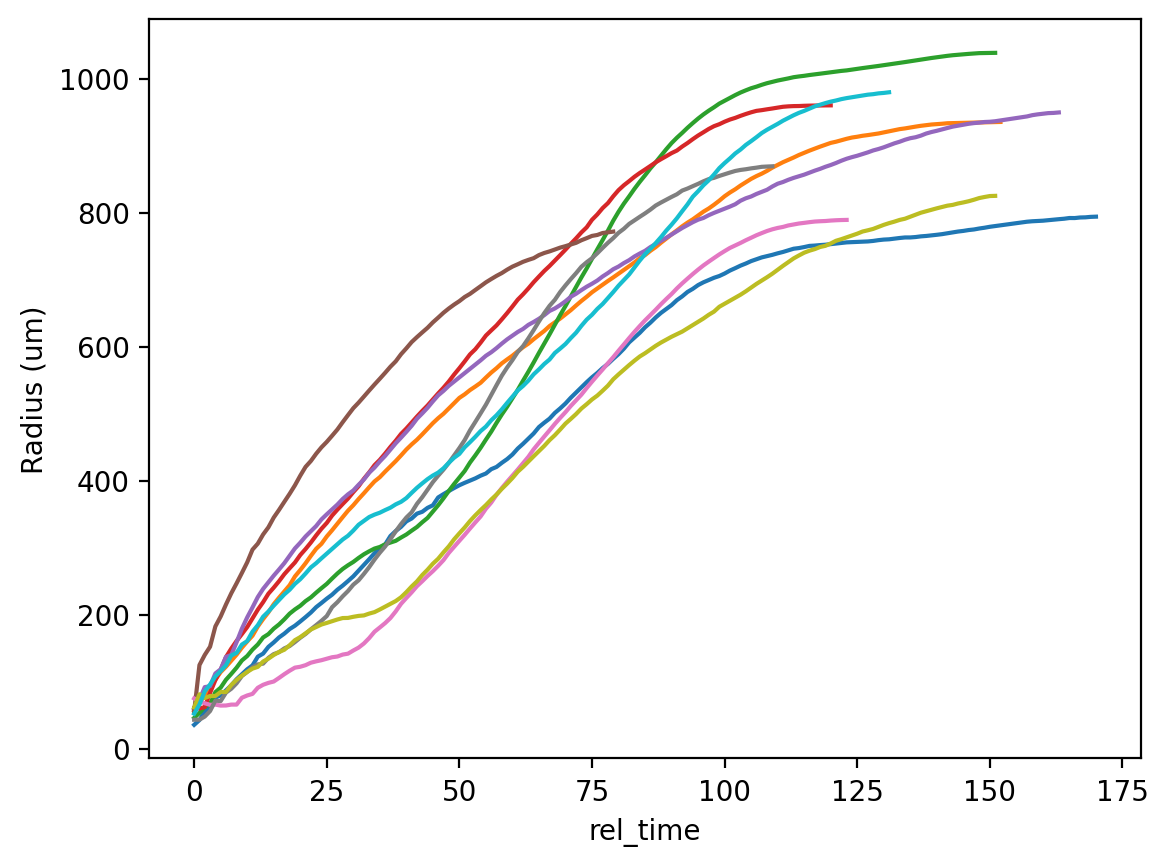

In [11]:
#Next are key wave analysis functions:
#Plotting all the waves in a set
plt.figure(dpi=200)
sns.lineplot(data=waves_linear_added[waves_linear_added['drug_name']=='DPI'], x='rel_time', y='linear_travel', hue='wave_ID', legend = False)
plt.ylabel('Radius (um)')

In [12]:
#collect control and sod-catalase wave max sizes: 

dpi_collect = []
control_collect = []


for wid, wave in waves_linear_added.groupby('wave_ID'):
    if wave.drug_name.values[0] == 'DPI':
        dpi_collect.append(wave.circle_radius.max())
    else:
        control_collect.append(wave.circle_radius.max())
    

In [13]:

DPI_max_DF = pd.DataFrame(dpi_collect, columns=['circle_radius'])
DPI_max_DF['drug'] = 'DPI'

control_max_DF = pd.DataFrame(control_collect, columns=['circle_radius'])
control_max_DF['drug'] = 'control'

combo_cond_DF = pd.concat([control_max_DF, DPI_max_DF], ignore_index=True)


In [14]:
#Common formatting:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

(-0.5, 1.5)

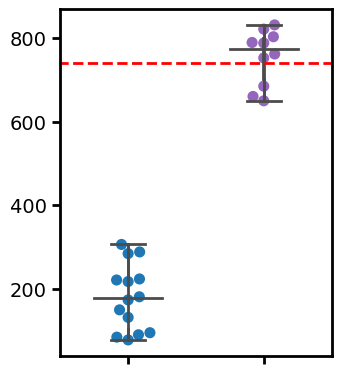

In [15]:
#Next are key wave analysis functions:

#Print out figure 2e: 
fig, ax = plt.subplots(figsize=(3.5,4.5))
sns.boxplot(data=combo_cond_DF, x='drug', y='circle_radius', palette=[sns.color_palette()[7],sns.color_palette()[7]],  width=0.005, ax=ax, zorder=1000)
sns.boxplot(data=combo_cond_DF, x='drug', y='circle_radius', palette=[sns.color_palette()[7],sns.color_palette()[7]],  showbox=False, width=0.5, ax=ax, zorder=1000)
sns.swarmplot(data=combo_cond_DF, x='drug', y='circle_radius', palette=[sns.color_palette()[0],sns.color_palette()[4]], size=8, ax=ax, zorder=-1)
ax.tick_params(direction='out', width=2.0, labelsize=14)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0,1],['',''])
plt.ylabel('')

plt.hlines(740,xmin=-1, xmax=2, linestyles="--", colors="red", linewidth=2)
plt.xlim(-0.5,1.5)

In [17]:
#collect control and sod-catalase wave max sizes: 

dpi_collect = []
control_collect = []


for wid, wave in waves_linear_added.groupby('wave_ID'):
    if wave.drug_name.values[0] == 'DPI':
        dpi_collect.append(wave.linear_travel.max())
    else:
        control_collect.append(wave.linear_travel.max())
    

In [18]:

DPI_max_DF = pd.DataFrame(dpi_collect, columns=['linear_travel'])
DPI_max_DF['drug'] = 'DPI'

control_max_DF = pd.DataFrame(control_collect, columns=['linear_travel'])
control_max_DF['drug'] = 'control'

combo_cond_DF_lin = pd.concat([control_max_DF, DPI_max_DF], ignore_index=True)


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

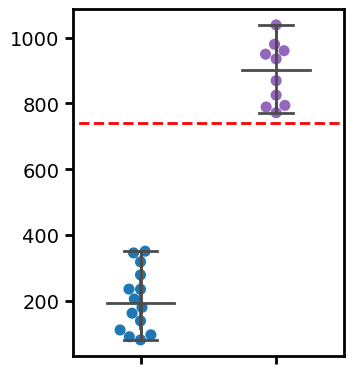

In [19]:

#Print out figure 2e: 
fig, ax = plt.subplots(figsize=(3.5,4.5))
sns.boxplot(data=combo_cond_DF_lin, x='drug', y='linear_travel', palette=[sns.color_palette()[7],sns.color_palette()[7]],  width=0.005, ax=ax, zorder=1000)
sns.boxplot(data=combo_cond_DF_lin, x='drug', y='linear_travel', palette=[sns.color_palette()[7],sns.color_palette()[7]],  showbox=False, width=0.5, ax=ax, zorder=1000)
sns.swarmplot(data=combo_cond_DF_lin, x='drug', y='linear_travel', palette=[sns.color_palette()[0],sns.color_palette()[4]], size=8, ax=ax, zorder=-1)
ax.tick_params(direction='out', width=2.0, labelsize=14)
#plt.ylim(0,50000)
plt.xlabel('')
plt.xticks([0,1],['',''])
plt.ylabel('')

plt.hlines(740,xmin=-1, xmax=2, linestyles="--", colors="red", linewidth=2)
plt.xlim(-0.5,1.5)
plt.savefig('fig3-supplement-normal-v-dpi-linear.png', dpi=300, bbox_inches='tight')

In [20]:
print("Number of Waves control: {}".format(len(control_collect)))
print("Volunteer IDs: {}".format(wave_con_df[wave_con_df['drug_name'].isnull()].volunteer_ID.unique()))

Number of Waves control: 14
Volunteer IDs: [14 16 21 22]


In [21]:
print("Number of Waves DPI: {}".format(len(dpi_collect)))
print("Volunteer IDs: {}".format(wave_con_df[wave_con_df['drug_name'] == 'DPI'].volunteer_ID.unique()))

Number of Waves DPI: 10
Volunteer IDs: [14 18 23 24 16 21 22]
